<a href="https://colab.research.google.com/github/Velmor/Python/blob/main/Time%20series%20analysis%20and%20visualization%20of%20stock%20and%20oil%20prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import yfinance as yf

# Download historical data for desired stocks
ticker_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

data = yf.download(ticker_symbols, start="2019-01-01", end="2023-01-01")


[*********************100%***********************]  4 of 4 completed


In [ ]:
!pip install quandl
import quandl

# Set your API key
quandl.ApiConfig.api_key = 'Jrf_-h4envczzgPyhUoD'

# Download oil price data
oil_data = quandl.get("OPEC/ORB", start_date="2019-01-01", end_date="2023-01-01")


In [ ]:
!pip install tsfresh


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 12.9 MB/s eta 0:00:00


In [ ]:
print(data.columns)

MultiIndex([('Adj Close',  'AAPL'),
            ('Adj Close',  'AMZN'),
            ('Adj Close', 'GOOGL'),
            ('Adj Close',  'MSFT'),
            (    'Close',  'AAPL'),
            (    'Close',  'AMZN'),
            (    'Close', 'GOOGL'),
            (    'Close',  'MSFT'),
            (     'High',  'AAPL'),
            (     'High',  'AMZN'),
            (     'High', 'GOOGL'),
            (     'High',  'MSFT'),
            (      'Low',  'AAPL'),
            (      'Low',  'AMZN'),
            (      'Low', 'GOOGL'),
            (      'Low',  'MSFT'),
            (     'Open',  'AAPL'),
            (     'Open',  'AMZN'),
            (     'Open', 'GOOGL'),
            (     'Open',  'MSFT'),
            (   'Volume',  'AAPL'),
            (   'Volume',  'AMZN'),
            (   'Volume', 'GOOGL'),
            (   'Volume',  'MSFT')],
           )


In [ ]:
import pandas as pd

In [ ]:
# Rename the oil_data column to match the stock data columns
oil_data.columns = ['Adj Close']

In [ ]:
# Add a level to the column names to match the stock data columns
oil_data.columns = pd.MultiIndex.from_product([oil_data.columns, ['OIL']])

In [ ]:
# Concatenate the stock data and oil data
data_combined = pd.concat([data, oil_data], axis=1)

# Convert the DataFrame from wide to long format
data_long = data_combined.stack().reset_index()

In [ ]:
# Rename the columns for clarity
data_long.columns = ['Date', 'Ticker', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [ ]:
# Melt the DataFrame to have a single value column
data_melted = data_long.melt(id_vars=['Date', 'Ticker'], var_name='Type', value_name='Value')

In [ ]:
# Create an id for each ticker to be used by tsfresh
data_melted['id'] = data_melted.groupby('Ticker').ngroup()

# Convert the 'Value' column to float
data_melted['Value'] = data_melted['Value'].astype(float)

In [ ]:
# Forward fill to handle NaN values
data_melted['Value'] = data_melted['Value'].fillna(method='ffill')

# Extract features
from tsfresh import extract_features
extracted_features = extract_features(data_melted, column_id='id', column_sort='Date', column_value='Value')


Feature Extraction: 100%|██████████| 5/5 [03:21<00:00, 40.25s/it]


In [ ]:
from tsfresh.feature_extraction import MinimalFCParameters, extract_features

# Define settings to only compute a minimal set of features
settings_minimal = MinimalFCParameters()

# Extract minimal features
extracted_features_minimal = extract_features(data_melted, column_id='id', column_sort='Date', column_value='Value', default_fc_parameters=settings_minimal)


Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 80.29it/s]


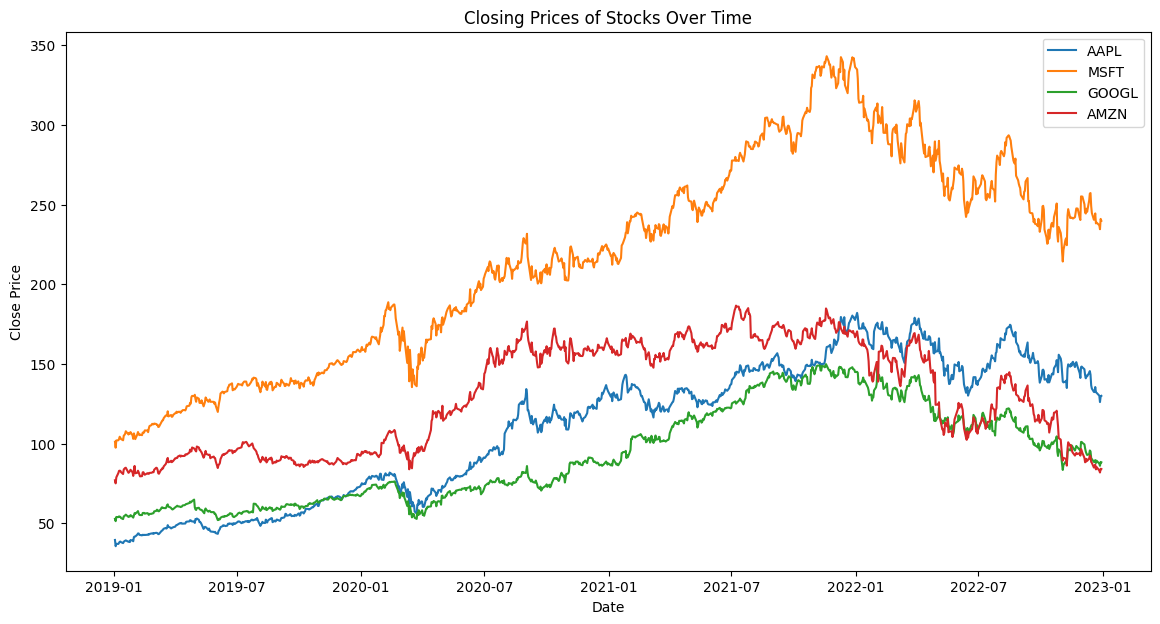

In [ ]:
import matplotlib.pyplot as plt

# Plot the closing prices
plt.figure(figsize=(14, 7))
for ticker in ticker_symbols:
    plt.plot(data['Close', ticker], label=ticker)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Closing Prices of Stocks Over Time')
plt.legend()
plt.show()


In [ ]:
import plotly.graph_objects as go

# Create an interactive plot of the closing prices
fig = go.Figure()
for ticker in ticker_symbols:
    fig.add_trace(go.Scatter(x=data.index, y=data['Close', ticker], name=ticker))
fig.update_layout(title='Closing Prices of Stocks Over Time', xaxis_title='Date', yaxis_title='Close Price')
fig.show()


In [ ]:
print(extracted_features_minimal.head())


   Value__sum_values  Value__median   Value__mean  Value__length  \
0       1.129971e+11     133.000725  1.868338e+07         6048.0   
1       8.061709e+10     152.313004  1.332954e+07         6048.0   
2       3.415048e+10     101.708752  5.646574e+06         6048.0   
3       3.011471e+10     241.644997  4.979283e+06         6048.0   
4       3.077138e+10     221.920006  4.964727e+06         6198.0   

   Value__standard_deviation  Value__variance  Value__root_mean_square  \
0               4.706339e+07     2.214963e+15             5.063627e+07   
1               3.299572e+07     1.088718e+15             3.558643e+07   
2               1.410132e+07     1.988471e+14             1.518983e+07   
3               1.228408e+07     1.508986e+14             1.325488e+07   
4               1.224839e+07     1.500230e+14             1.321634e+07   

   Value__maximum  Value__absolute_maximum  Value__minimum  
0     426510000.0              426510000.0       34.209957  
1     311346000.0       

In [ ]:
print(extracted_features_minimal.describe())


       Value__sum_values  Value__median   Value__mean  Value__length  \
count       5.000000e+00       5.000000  5.000000e+00       5.000000   
mean        5.773014e+10     170.117496  9.520701e+06    6078.000000   
std         3.749544e+10      59.527503  6.221980e+06      67.082039   
min         3.011471e+10     101.708752  4.964727e+06    6048.000000   
25%         3.077138e+10     133.000725  4.979283e+06    6048.000000   
50%         3.415048e+10     152.313004  5.646574e+06    6048.000000   
75%         8.061709e+10     221.920006  1.332954e+07    6048.000000   
max         1.129971e+11     241.644997  1.868338e+07    6198.000000   

       Value__standard_deviation  Value__variance  Value__root_mean_square  \
count               5.000000e+00     5.000000e+00             5.000000e+00   
mean                2.373858e+07     7.606899e+14             2.557675e+07   
std                 1.569911e+07     9.059442e+14             1.688690e+07   
min                 1.224839e+07     1.

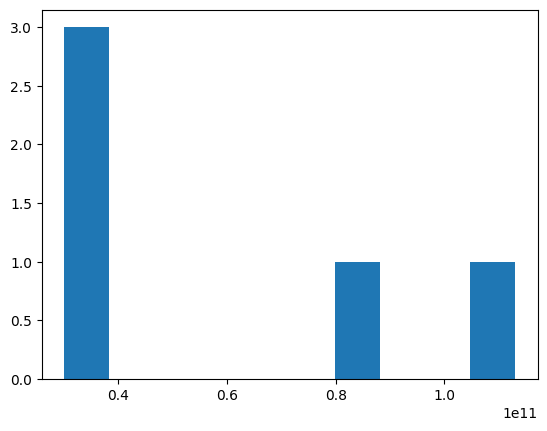

In [ ]:
import matplotlib.pyplot as plt

# Plot a histogram of the first feature
plt.hist(extracted_features_minimal.iloc[:, 0].dropna())
plt.show()


In [ ]:
# Compute the correlation matrix
corr_matrix = extracted_features_minimal.corr()

# Print the correlation matrix
print(corr_matrix)


                           Value__sum_values  Value__median  Value__mean  \
Value__sum_values                   1.000000      -0.472395     0.999967   
Value__median                      -0.472395       1.000000    -0.475004   
Value__mean                         0.999967      -0.475004     1.000000   
Value__length                      -0.401926       0.486472    -0.409334   
Value__standard_deviation           0.999874      -0.477733     0.999906   
Value__variance                     0.989374      -0.447973     0.989157   
Value__root_mean_square             0.999898      -0.477362     0.999930   
Value__maximum                      0.997733      -0.522797     0.998009   
Value__absolute_maximum             0.997733      -0.522797     0.998009   
Value__minimum                     -0.109699       0.166397    -0.103005   

                           Value__length  Value__standard_deviation  \
Value__sum_values              -0.401926                   0.999874   
Value__median        

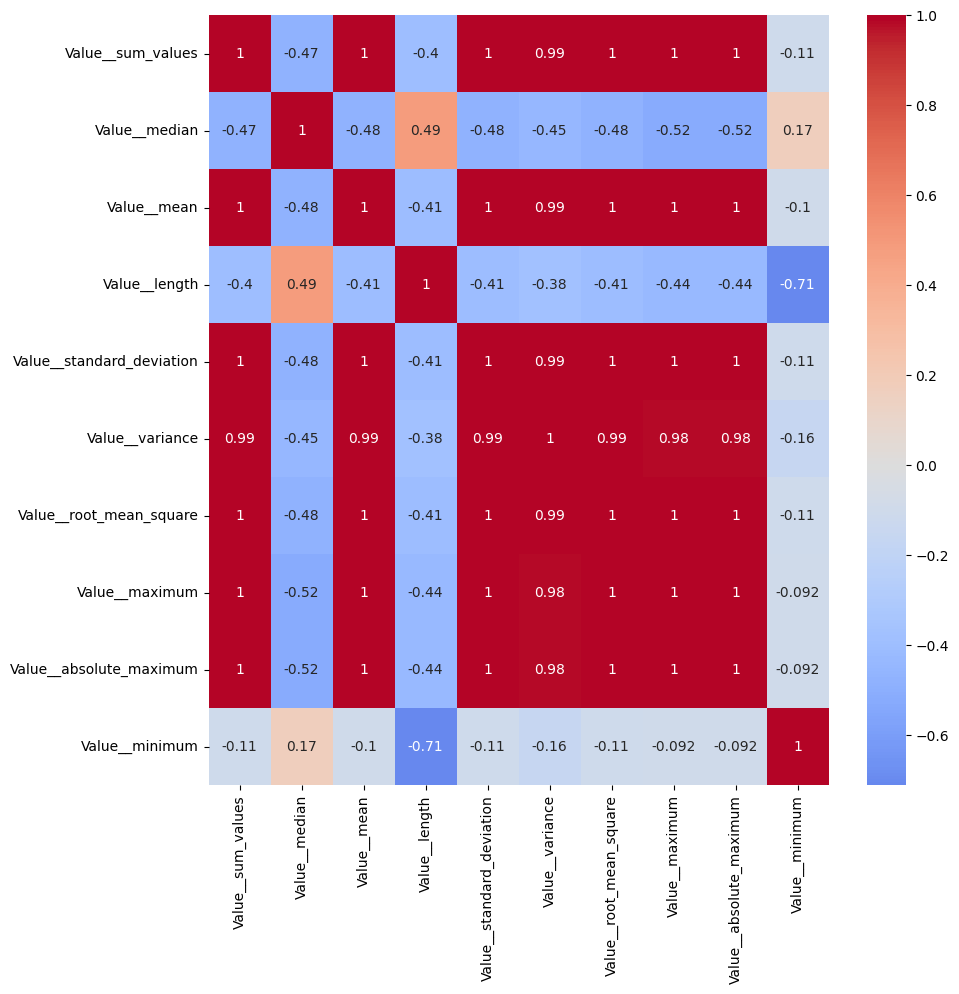

In [ ]:
import seaborn as sns

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True)
plt.show()
